In [1]:
import time
import datetime
import pickle
import random
import json

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers

from torch.utils.data import random_split
from collections import defaultdict, Counter
from transformers import BertForMaskedLM, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import statsmodels.stats.proportion

device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
# we will use prepared artificial sentences
pos_neg = []
for neg, pos in zip(open('10k_neg.txt', encoding='utf-8'), open('10k_aff.txt', encoding='utf-8')):
    pos_neg.append( (pos.strip(), neg.strip()) )
    
ten_k = pd.read_csv('modifiers_all.csv',index_col=0).head(10000)

genders = pickle.load( open( "noun_genders.pkl", "rb" ) )

In [3]:
# first, we will try to make a short list of degree modifiers using simple positive and negative contexts:

def assess(sentence):
    sentence = sentence.replace('[mask]', '[MASK]')
    tokens = tokenizer.tokenize(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    segment_ids = [0] * len(tokens)
    n = tokens.index('[MASK]')

    input_ids = torch.tensor([input_ids,], dtype=torch.long).to(device)
    segment_ids = torch.tensor([segment_ids,], dtype=torch.long).to(device)

    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)

    return probs[0][n].cpu().detach().numpy()

pos_probs = []
neg_probs = []
candidates = []

USE_CANDIDATES = 100

for idx,( pos, neg)  in enumerate(pos_neg):
    if not idx%1000:
        print(idx, pos, neg)
    probs = assess( pos.lower() )
    indices = [x[0] for x in sorted(enumerate(probs), key=lambda x:-x[1])]
    candidates.extend( indices[:USE_CANDIDATES] )
    pos_probs.append( probs )

    probs = assess( neg.lower() )
    indices = [x[0] for x in sorted(enumerate(probs), key=lambda x:-x[1])]
    candidates.extend( indices[:USE_CANDIDATES] )
    neg_probs.append( probs )


0 The reason is [MASK] simple. The reason isn't [MASK] simple.
1000 The design is [MASK] interesting. The design isn't [MASK] interesting.
2000 The risk is [MASK] serious. The risk isn't [MASK] serious.
3000 The text is [MASK] terrible. The text isn't [MASK] terrible.
4000 The list is [MASK] important. The list isn't [MASK] important.
5000 The challenge is [MASK] amazing. The challenge isn't [MASK] amazing.
6000 The details are [MASK] remarkable. The details aren't [MASK] remarkable.
7000 The relationship is [MASK] remarkable. The relationship isn't [MASK] remarkable.
8000 The model is [MASK] big. The model isn't [MASK] big.
9000 The region is [MASK] small. The region isn't [MASK] small.


In [9]:
def score_token(token):
    token_id = tokenizer.vocab[token]
    return np.sum( [1. for pps, nps in zip(pos_probs, neg_probs) if pps[token_id]>nps[token_id]] ), len(pos_probs)

candidates_freqs = Counter(candidates)
candidates_rating = [reverse_vocab[x] for x,c in candidates_freqs.most_common()]

with open('polarity_scores_adj.tsv', 'w', encoding='utf-8') as ofh:
    for word in candidates_rating:
        s, n = score_token(word)
        c = candidates_freqs[tokenizer.vocab[word]]
        if c>=100:
            mean = s/n
            print(f'{word}\t{c}\t{mean}\t{n}\t{s}', file=ofh, flush=True)


In [6]:
# we will use two pairs of well known degree modifiers to detect sets of auxiliary particles for high/low classes

modifiers = ['very', 'extremely', 'somewhat','slightly']

simple_res_probs = defaultdict(list)
candidates = []

USE_CANDIDATES = 100

for idx,(id,row) in enumerate(ten_k.iterrows()):
    words = row['sentence'].split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    if not idx%1000:
        print(idx, words)
    for m in modifiers:
        if copula == 'is':
            sent = f'Is the {noun} {adjective}? [MASK] , {genders[noun]} is {m} {adjective}.'
        else:
            sent = f'Are the {noun} {adjective}? [MASK] , {genders[noun]} are {m} {adjective}.'
        probs = assess( sent.lower() )
        indices = [x[0] for x in sorted(enumerate(probs), key=lambda x:-x[1])]
        candidates.extend( indices[:USE_CANDIDATES] )
        simple_res_probs[m].append( probs )


0 ['The', 'reason', 'is', 'simple.']
1000 ['The', 'design', 'is', 'interesting.']
2000 ['The', 'risk', 'is', 'serious.']
3000 ['The', 'text', 'is', 'terrible.']
4000 ['The', 'list', 'is', 'important.']
5000 ['The', 'challenge', 'is', 'amazing.']
6000 ['The', 'details', 'are', 'remarkable.']
7000 ['The', 'relationship', 'is', 'remarkable.']
8000 ['The', 'model', 'is', 'big.']
9000 ['The', 'region', 'is', 'small.']


In [ ]:
simple_candidates_freqs = Counter(candidates)
simple_candidates_rating = [reverse_vocab[x] for x,c in simple_candidates_freqs.most_common()]

slightly_probs = np.array( simple_res_probs['slightly'] )
somewhat_probs = np.array( simple_res_probs['somewhat'] )
extremely_probs = np.array( simple_res_probs['extremely'] )
very_probs = np.array( simple_res_probs['very'] )

high_particles = []
low_particles = []

for word in simple_candidates_rating:
    token_id = tokenizer.vocab[word]
    if simple_candidates_freqs[token_id]<100: continue
    lv1, lv2 = slightly_probs[:,token_id], somewhat_probs[:,token_id], 
    hv1, hv2 = extremely_probs[:,token_id], very_probs[:,token_id]
    stats = [(lc1<hc1, lc2<hc2, lc2<hc1, lc1<hc2) for lc1, lc2, hc1, hc2 in zip(lv1, lv2, hv1, hv2)]
    s1, s2, s3, s4 = list(map(lambda x: np.sign(np.sum(x)/slightly_probs.shape[0]-0.5),zip(*stats)))
    sv = np.array([s1, s2, s3, s4])
    if np.all(sv>0.):
        high_particles.append( word )
    if np.all(sv<0.):
        low_particles.append( word )
    if len(high_particles)>=10 and len(low_particles)>=10:
        break

high_particles = high_particles[:10]
low_particles = low_particles[:10]

In [16]:
del(simple_res_probs)
del(slightly_probs)
del(somewhat_probs)
del(extremely_probs)
del(very_probs)
del(pos_probs)
del(neg_probs)

In [17]:
# here are the lists of resulting particles we will use to measure degree modifying properties
low_particles  = ['well', 'actually', 'now', 'but', 'however', 'still', 'so', 'why', 'anyway', 'sure']
high_particles = ['yes', 'oh', 'sir', 'absolutely', 'god', 'damn', 'remember', 'wow', 'seriously', 'man']

In [18]:
# here is the list of manually preselected modifiers we will assess first
modifiers = ['rather', 'probably', 'fairly', 'relatively', 'somewhat', 'hardly', 'sometimes', 'generally', 'rarely', 
             'slightly', 'comparatively', 'moderately', 'mildly', 'partly', 'perhaps', 'possibly', 'very', 'quite', 
             'definitely', 'pretty', 'truly', 'surely', 'deeply', 'kinda', 'practically', 'genuinely', 'profoundly', 
             'greatly', 'consistently', 'decidedly', 'solid', 'incredibly', 'absolutely', 'beyond', 'utterly', 
             'painfully', 'positively', 'mighty', 'seriously', 'desperately', 'dangerously', 'intensely', 'filthy', 
             'wicked', 'ultra', 'fiercely', 'hot', 'blazing', 'steaming', 'pitch', 'glowing', 'significantly', 'really', 
             'completely', 'especially', 'simply', 'perfectly', 'nearly', 'fully', 'barely', 'inherently', 'normally', 
             'full', 'permanently', 'totally', 'fucking', 'bloody', 'damn', 'super', 'freaking', 'awful', 'crazy', 
             'goddamn', 'horribly', 'absolute', 'burning', 'flipping', 'perfect', 'boiling', 'violently', 'merely', 
             'altogether', 'always', 'all', 'real', 'particularly', 'exactly', 'overly', 'wholly', 'easily', 'precisely', 
             'half', 'over', 'too', 'so', 'that', 'this', 'smoking']

In [24]:
# next we will evaluate the degree modification property of our new tokens 
def assess_batch(texts):
    batch_input_ids = []
    batch_segment_ids = []
    n_pos = []
    for sentence in texts:
        sentence = sentence.replace('[mask]', '[MASK]')
        tokens = tokenizer.tokenize(sentence)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(tokens)
        n = tokens.index('[MASK]')
        n_pos.append( n )
        batch_input_ids.append( input_ids )
        batch_segment_ids.append( segment_ids )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    res = []
    for n, probs_item in zip(n_pos, probs):
        res.append( probs_item[n].cpu().detach().numpy() )
    return res

degree_mod_scores = defaultdict(int)

for idx,(id,row) in enumerate(ten_k.iterrows()):
#     if idx%19: continue # we don't need the full data, it's enought to use a subsample
    words = row['sentence'].split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    sents = []
    for h in low_particles+high_particles:
        if copula == 'is':
            sent = f'Is the {noun} {adjective}? {h}, {genders[noun]} is [MASK] {adjective}.'
        else:
            sent = f'Are the {noun} {adjective}? {h}, {genders[noun]} are [MASK] {adjective}.'
        sents.append( sent.lower() )

    batch_probs = assess_batch( sents )

    for c_mod in modifiers:
        c = tokenizer.vocab[c_mod]
        for h1,h2 in zip(np.random.permutation(list(range(10))),np.random.permutation(list(range(10,20)))):
            degree_mod_scores['_total_'] += 1
            if batch_probs[h1][c]<batch_probs[h2][c]:
                degree_mod_scores[reverse_vocab[c]] += 1
    if not idx%1000:
        print(idx, words)
tt = degree_mod_scores['_total_']/len(modifiers)

0 ['The', 'reason', 'is', 'simple.']
1000 ['The', 'design', 'is', 'interesting.']
2000 ['The', 'risk', 'is', 'serious.']
3000 ['The', 'text', 'is', 'terrible.']
4000 ['The', 'list', 'is', 'important.']
5000 ['The', 'challenge', 'is', 'amazing.']
6000 ['The', 'details', 'are', 'remarkable.']
7000 ['The', 'relationship', 'is', 'remarkable.']
8000 ['The', 'model', 'is', 'big.']
9000 ['The', 'region', 'is', 'small.']


[('partly', 0.09535), ('rather', 0.11032), ('mildly', 0.11598), ('somewhat', 0.11932), ('relatively', 0.13367), ('comparatively', 0.13905), ('hardly', 0.14155), ('slightly', 0.15753), ('generally', 0.1786), ('perhaps', 0.18678), ('fairly', 0.18896), ('significantly', 0.19587), ('moderately', 0.23424), ('rarely', 0.23432), ('possibly', 0.25656), ('probably', 0.27052), ('altogether', 0.27914), ('sometimes', 0.29846), ('merely', 0.31754), ('genuinely', 0.32211), ('decidedly', 0.32612), ('quite', 0.32641), ('consistently', 0.33628), ('normally', 0.33932), ('barely', 0.34416), ('overly', 0.35646), ('precisely', 0.35814), ('fully', 0.35896), ('easily', 0.37194), ('greatly', 0.37808), ('perfectly', 0.38199), ('wholly', 0.38632), ('exactly', 0.40076), ('particularly', 0.41368), ('full', 0.42131), ('pretty', 0.42755), ('kinda', 0.43264), ('solid', 0.43467), ('simply', 0.44331), ('permanently', 0.44721), ('very', 0.45123), ('always', 0.45281), ('deeply', 0.45577), ('half', 0.4589), ('nearly', 0.

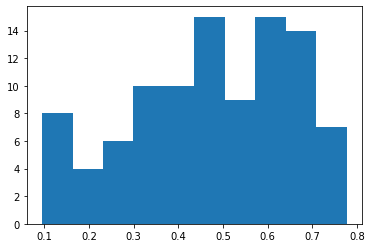

In [30]:
dmod_scores = [degree_mod_scores[m]/tt for m in modifiers]
print(list(sorted(zip(modifiers, dmod_scores),key=lambda x:x[1])))

plt.hist(dmod_scores)
plt.show()

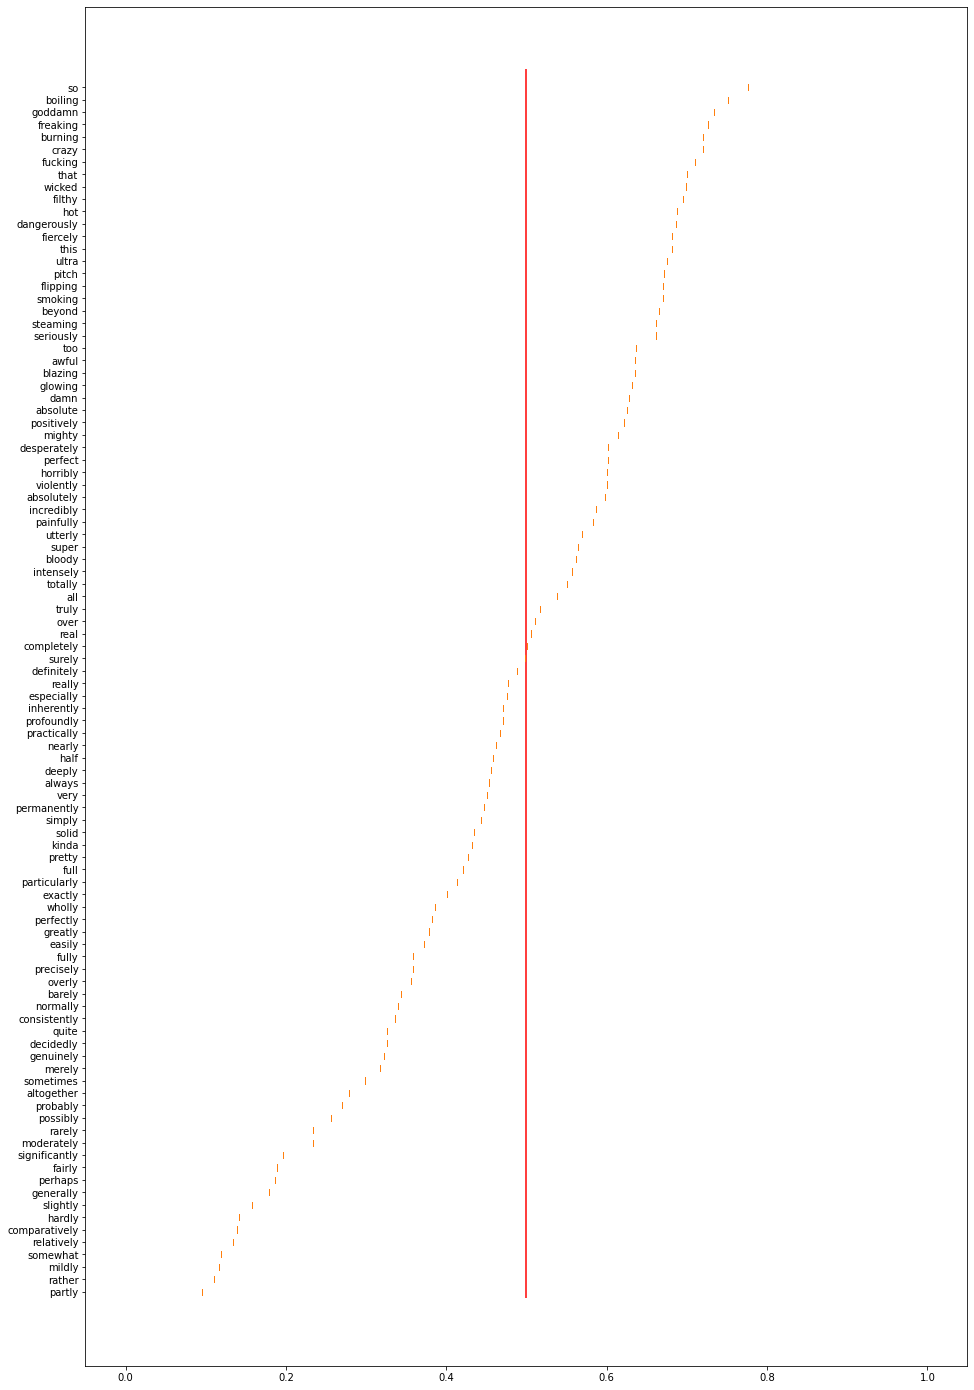

In [29]:
boxes = []
titles = []

for idx,word in enumerate(modifiers):
    mean = dmod_scores[idx]
    boxes.append( {'med': mean, 'q1': mean, 'q3': mean, 'whislo': mean, 'whishi': mean} )
    titles.append( word )
    
dgr_mod, boxes, titles = zip(*[(x[0]['med'], x[0], x[1])  for x in sorted(zip(boxes, titles), key=lambda x:x[0]['med'])])
f, ax = plt.subplots(figsize=(35,25));

ax.bxp(boxes, showfliers=False,vert=0);
ax.vlines(0.5,0.5,len(boxes)+1.5,color='red')
ax.vlines(0.0,0.0,len(boxes)+0.5,color='white')
ax.vlines(1.0,1.0,len(boxes)+0.5,color='white')

locs, labels = plt.yticks()
plt.yticks(locs, titles)
plt.subplots_adjust(left=0.55)
plt.show()

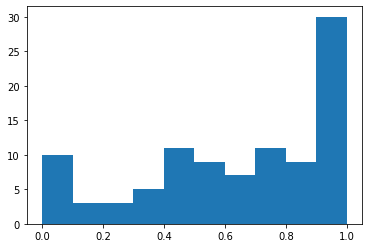

In [32]:
# now we will evaluate polarity of our modifiers

def _process(sentence, tokenizer, model):
    sentence = sentence.replace('[mask]', '[MASK]')
    tokens = tokenizer.tokenize(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    segment_ids = [0] * len(tokens)
    n = tokens.index('[MASK]')

    input_ids = torch.tensor([input_ids,], dtype=torch.long).to(device)
    segment_ids = torch.tensor([segment_ids,], dtype=torch.long).to(device)
    
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)

    return probs[0][n].cpu().detach().numpy()

def new_mod_preds(mod_index, pos_neg, tokenizer, model, dbg=False):
    result = defaultdict(list)
    
    for idx,(pos, neg)  in enumerate(pos_neg):
        preds_aff = _process(pos.lower(), tokenizer, model)
        preds_neg = _process(neg.lower(), tokenizer, model)
        for i, m_idx in enumerate(mod_index):
            diff = preds_aff[m_idx].item() - preds_neg[m_idx].item()
            result[i].append(diff)
        if dbg and idx and not idx % 1000:
            print( np.mean(np.array(list(result.values())), axis=1)[:10] )
    return result

def evaluate_polarity(mod_index, pos_neg, tokenizer, model):
    result = new_mod_preds(mod_index, pos_neg, tokenizer, model)
    rr = np.array(list(result.values()))
#     print( np.count_nonzero(rr>0.,axis=1)/rr.shape[1] )
    return np.count_nonzero(rr>0.,axis=1)/rr.shape[1]

polarity_scores = evaluate_polarity([tokenizer.vocab[c_mod] for c_mod in modifiers], pos_neg, tokenizer, model)
plt.hist(polarity_scores)
plt.show()

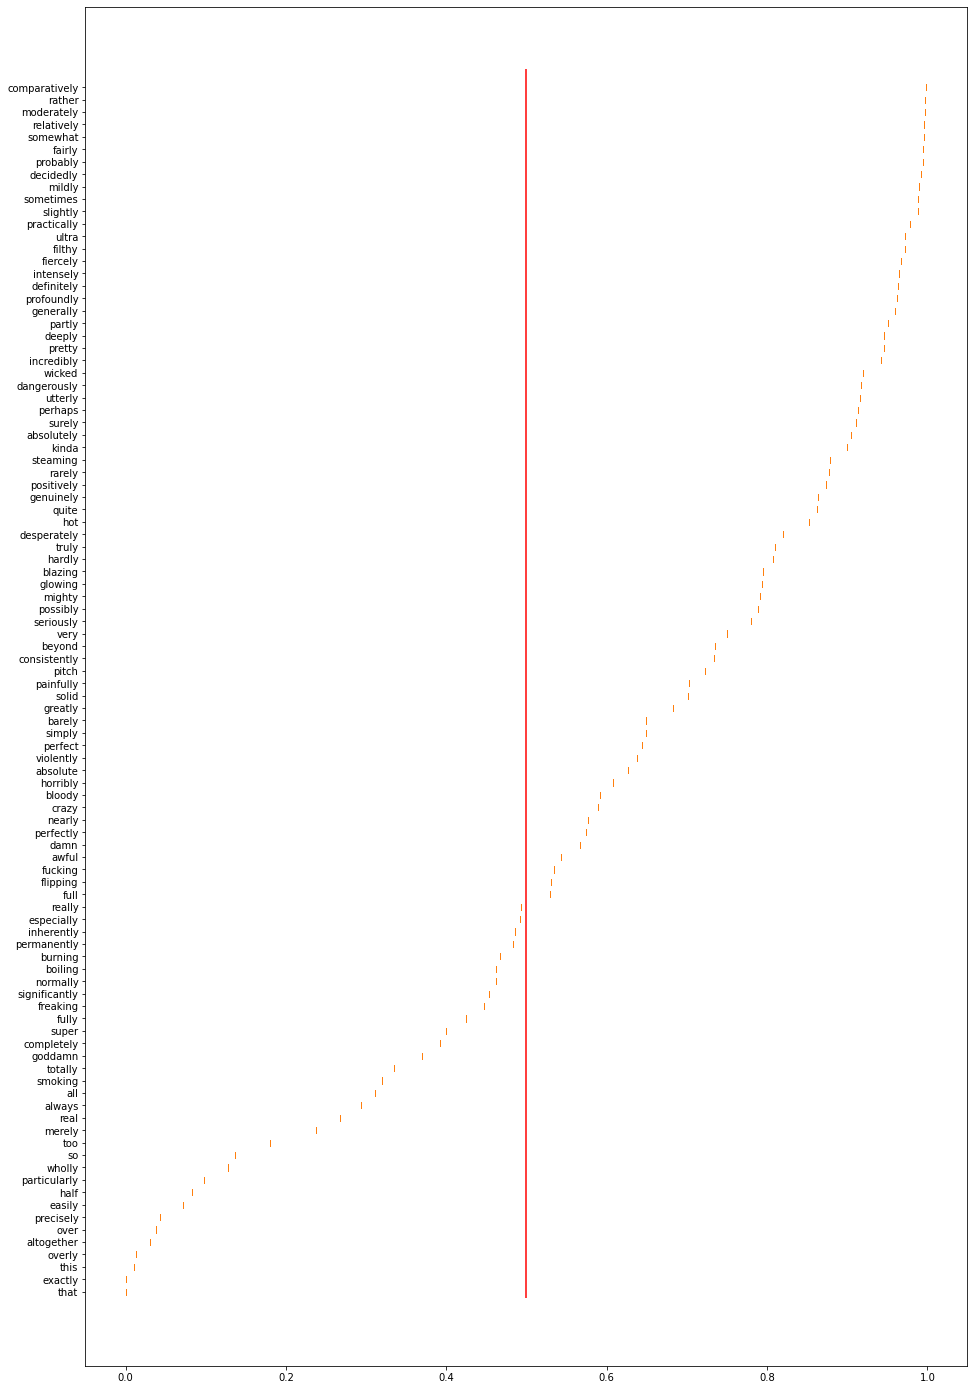

In [33]:
boxes = []
titles = []

for idx,word in enumerate(modifiers):
    mean = polarity_scores[idx]
    boxes.append( {'med': mean, 'q1': mean, 'q3': mean, 'whislo': mean, 'whishi': mean} )
    titles.append( word )
    
dgr_mod, boxes, titles = zip(*[(x[0]['med'], x[0], x[1])  for x in sorted(zip(boxes, titles), key=lambda x:x[0]['med'])])
f, ax = plt.subplots(figsize=(35,25));

ax.bxp(boxes, showfliers=False,vert=0);
ax.vlines(0.5,0.5,len(boxes)+1.5,color='red')
ax.vlines(0.0,0.0,len(boxes)+0.5,color='white')
ax.vlines(1.0,1.0,len(boxes)+0.5,color='white')

locs, labels = plt.yticks()
plt.yticks(locs, titles)
plt.subplots_adjust(left=0.55)
plt.show()


In [35]:
with open('modifiers_scores.tsv', 'w', encoding='utf-8') as ofh:
    print('modifier\tdmod_score\tpolarity_score')
    print('modifier\tdmod_score\tpolarity_score', file=ofh)
    for m, d_score, p_score in zip(modifiers, dmod_scores, polarity_scores):
        print(f'{m}\t{d_score}\t{p_score}')
        print(f'{m}\t{d_score}\t{p_score}', file=ofh)
        

modifier	dmod_score	polarity_score
rather	0.11032	0.9971
probably	0.27052	0.9946
fairly	0.18896	0.9946
relatively	0.13367	0.9956
somewhat	0.11932	0.9954
hardly	0.14155	0.8072
sometimes	0.29846	0.9886
generally	0.1786	0.9591
rarely	0.23432	0.8769
slightly	0.15753	0.9883
comparatively	0.13905	0.9978
moderately	0.23424	0.9969
mildly	0.11598	0.9898
partly	0.09535	0.9505
perhaps	0.18678	0.9135
possibly	0.25656	0.7888
very	0.45123	0.7506
quite	0.32641	0.8624
definitely	0.4881	0.9633
pretty	0.42755	0.9454
truly	0.51746	0.8104
surely	0.49865	0.9109
deeply	0.45577	0.9454
kinda	0.43264	0.9004
practically	0.4675	0.9788
genuinely	0.32211	0.8633
profoundly	0.47046	0.9625
greatly	0.37808	0.6831
consistently	0.33628	0.7342
decidedly	0.32612	0.9919
solid	0.43467	0.7012
incredibly	0.58703	0.9428
absolutely	0.5982	0.905
beyond	0.66474	0.7353
utterly	0.56912	0.9162
painfully	0.58294	0.7026
positively	0.62107	0.8738
mighty	0.61375	0.791
seriously	0.66167	0.7795
desperately	0.60158	0.8197
dangerously	0.687

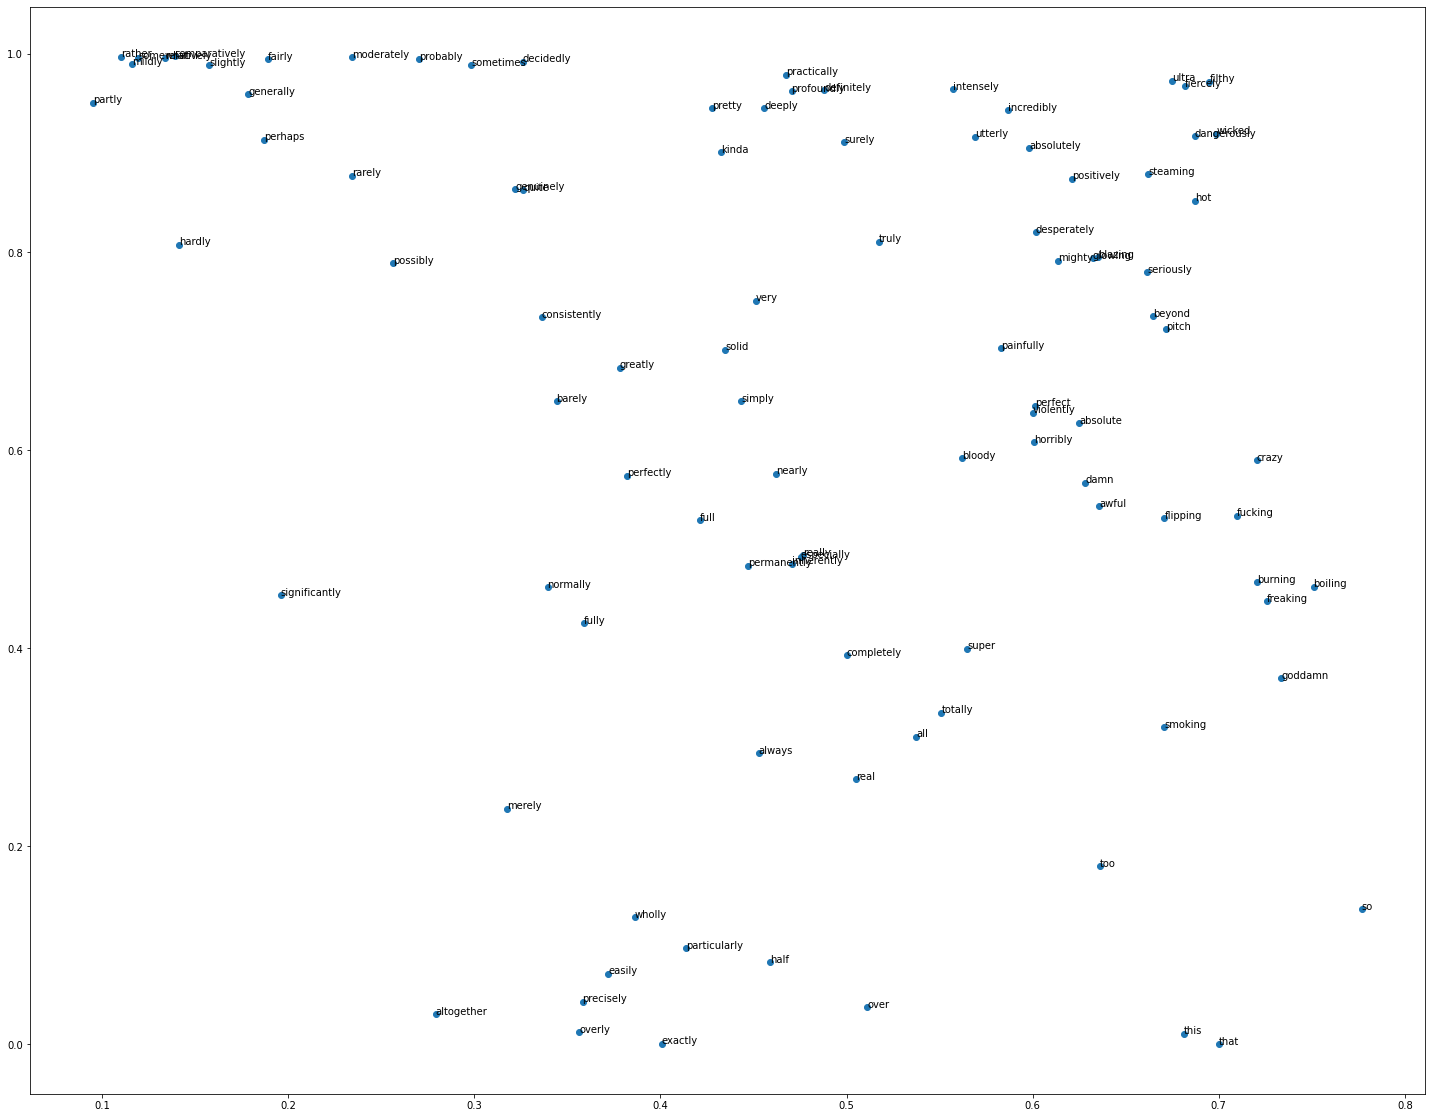

In [40]:
y = []
x = []
n = []

for idx, line in enumerate(open('modifiers_scores.tsv', encoding='utf-8')):
    if not idx:continue
    chunks = line.strip().split('\t')
    y.append(float(chunks[2]))
    x.append(float(chunks[1]))
    n.append(chunks[0])

f, ax = plt.subplots(figsize=(25,20));
ax.scatter(x, y)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [9]:
# we will use our preselected modifiers
# to make a longer list of auxiliary particles candidates 

candidates = Counter()

USE_CANDIDATES = 100

for idx,(id,row) in enumerate(ten_k.iterrows()):
    if idx%19: continue
    words = row['sentence'].split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    sents = []
    for m in modifiers:
        if copula == 'is':
            sent = f'Is the {noun} {adjective}? [MASK] , {genders[noun]} is {m} {adjective}.'
        else:
            sent = f'Are the {noun} {adjective}? [MASK] , {genders[noun]} are {m} {adjective}.'
        sents.append( sent.lower() )
    batch_probs = assess_batch( sents )
    for probs in batch_probs:
        indices = [x[0] for x in sorted(enumerate(probs), key=lambda x:-x[1])]
        candidates.update( indices[:USE_CANDIDATES] )
    if not idx%(19*50):
        print(idx, words,[(reverse_vocab[t], c) for t, c in candidates.most_common(5)] )


0 ['The', 'reason', 'is', 'simple.'] [('no', 98), ('yes', 98), ('well', 98), ('actually', 98), ('oh', 98)]
950 ['The', 'music', 'is', 'clear.'] [('no', 4998), ('yes', 4998), ('well', 4998), ('actually', 4998), ('but', 4998)]
1900 ['The', 'names', 'are', 'real.'] [('no', 9898), ('yes', 9898), ('well', 9898), ('actually', 9898), ('but', 9898)]
2850 ['The', 'game', 'is', 'personal.'] [('no', 14798), ('yes', 14798), ('well', 14798), ('actually', 14798), ('but', 14798)]
3800 ['The', 'money', 'is', 'fine.'] [('no', 19698), ('yes', 19698), ('well', 19698), ('actually', 19698), ('but', 19698)]
4750 ['The', 'format', 'is', 'complex.'] [('no', 24598), ('yes', 24598), ('well', 24598), ('actually', 24598), ('but', 24598)]
5700 ['The', 'box', 'is', 'incredible.'] [('no', 29498), ('yes', 29498), ('well', 29498), ('actually', 29498), ('but', 29498)]
6650 ['The', 'power', 'is', 'excellent.'] [('no', 34398), ('yes', 34398), ('well', 34398), ('actually', 34398), ('but', 34398)]
7600 ['The', 'materials',

In [10]:
print(len(candidates))

with open('auxiliary_particles_candidates.tsv', 'w', encoding='utf-8') as ofh:
    for c, cnt in candidates.most_common():
        print(f'{reverse_vocab[c]}\t{c}\t{cnt}', file=ofh)

681


In [11]:
# take only frequent candidates
freq_candidates = [hc for hc,hc_cnt in candidates.most_common() if hc_cnt>=100]
print(len(freq_candidates))

371


In [12]:
# measure probabilities of selected particles in contexts of selected modifiers

res_probs = defaultdict(list)

for idx,(id,row) in enumerate(ten_k.iterrows()):
    # if idx%19: continue
    words = row['sentence'].split(' ')
    adjective = words[3].rstrip('.')
    noun = words[1]
    copula = words[2]
    sents = []
    for m in modifiers:
        if copula == 'is':
            sent = f'Is the {noun} {adjective}? [MASK] , {genders[noun]} is {m} {adjective}.'
        else:
            sent = f'Are the {noun} {adjective}? [MASK] , {genders[noun]} are {m} {adjective}.'
        sents.append( sent.lower() )
    batch_probs = assess_batch( sents )
    for m, probs in zip(modifiers,batch_probs):
        for hc in freq_candidates:
            res_probs[(m,reverse_vocab[hc])].append(probs[hc])
    if not idx%(19*50):
        print(idx, words, [(reverse_vocab[t], c) for t, c in candidates.most_common(5)] )

0 ['The', 'reason', 'is', 'simple.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]
950 ['The', 'music', 'is', 'clear.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]
1900 ['The', 'names', 'are', 'real.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]
2850 ['The', 'game', 'is', 'personal.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]
3800 ['The', 'money', 'is', 'fine.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]
4750 ['The', 'format', 'is', 'complex.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]
5700 ['The', 'box', 'is', 'incredible.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]
6650 ['The', 'power', 'is', 'excellent.'] [('no', 51646), ('yes', 51646), ('well', 51646), ('actually', 51646), ('but', 51646)]

In [13]:
# we split our modifiers into 3 groups by the power of degree modification
mgroups_v = {
    'v1': ['rather', 'probably', 'fairly', 'relatively', 'somewhat', 'hardly', 'sometimes', 'generally', 'rarely', 
           'slightly', 'comparatively', 'moderately', 'mildly', 'partly', 'perhaps', 'possibly','significantly',
           'merely', 'altogether'],
    'v2': ['very', 'quite', 'definitely', 'pretty', 'truly', 'surely', 'deeply', 'kinda', 'practically', 'genuinely', 
           'profoundly', 'greatly', 'consistently', 'decidedly', 'solid', 'really', 'completely', 'especially', 'simply', 
           'perfectly', 'nearly', 'fully', 'barely', 'inherently', 'normally', 'full', 'permanently','always', 'all', 
           'real', 'particularly', 'exactly', 'overly', 'wholly', 'easily', 'precisely', 'half', 'over'],
    'v3': ['incredibly', 'absolutely', 'beyond', 'utterly', 'painfully', 'positively', 'mighty', 'seriously', 
           'desperately', 'dangerously', 'intensely', 'filthy', 'wicked', 'ultra', 'fiercely', 'hot', 'blazing', 
           'steaming', 'pitch', 'glowing', 'totally', 'fucking', 'bloody', 'damn', 'super', 'freaking', 'awful', 
           'crazy', 'goddamn', 'horribly', 'absolute', 'burning', 'flipping', 'perfect', 'boiling', 'violently',
           'too', 'so', 'that', 'this', 'smoking'],
}


In [23]:
# calculate the matrix with scores: 
# how often the modifier1 is more probable than the modifier2 in the presence of the given particle

values = dict()
for j,particle_id in enumerate(freq_candidates):
    particle = reverse_vocab[particle_id]
    matrix = []
    for m in modifiers:
        matrix.append( res_probs[(m,particle)] )
    matrix = np.array(matrix)
    tt = matrix[:, np.newaxis] - matrix
    for i1, m1 in enumerate(modifiers):
        for i2, m2 in enumerate(modifiers):
            values[(particle,m1,m2)] = np.count_nonzero(tt[i1,i2,:]>0.)/tt.shape[2] 

In [28]:
# for each of 3 groups calculate most probable and most improbable particles:

for mg in mgroups_v:
    active = mgroups_v[mg]
    others = list(set(modifiers)-set(active))

    stats = defaultdict(int)
    for m1 in active:
        for m2 in others:
            for h in freq_candidates:
                particle = reverse_vocab[h]
                stats[particle] += 0
                if values[(particle,m1,m2)]>0.5:
                    stats[particle] += 1

    stats = list(sorted(stats.items(), key=lambda x:-x[1]))
    print('group',mg)
    print('- best',stats[:16])
    print('- worst',stats[-16:])
    print('===\n')

group v1
- best [('alternatively', 1404), ('myself', 1382), ('similarly', 1376), ('accordingly', 1365), ('otherwise', 1364), ('however', 1362), ('alternately', 1355), ('likewise', 1353), ('conversely', 1351), ('er', 1346), ('although', 1345), ('thus', 1338), ('nevertheless', 1328), ('nonetheless', 1326), ('still', 1325), ('hence', 1320)]
- worst [('mama', 139), ('mine', 138), ('tom', 137), ('ana', 135), ('melissa', 133), ('jack', 132), ('love', 126), ('oh', 121), ('christ', 120), ('god', 113), ('chloe', 108), ('daddy', 105), ('kate', 89), ('mia', 87), ('princess', 83), ('beautiful', 71)]
===

group v2
- best [('yes', 1413), ('once', 1394), ('naturally', 1392), ('evidently', 1386), ('eventually', 1357), ('not', 1354), ('surely', 1349), ('nowadays', 1346), ('however', 1339), ('someday', 1339), ('fortunately', 1333), ('here', 1331), ('presumably', 1328), ('ideally', 1325), ('accordingly', 1321), ('hopefully', 1319)]
- worst [('correction', 758), ('boys', 755), ('slowly', 747), ('fuck', 73

In [ ]:
# we will use these particles in the next ipython notebook to train artificial degree modifiers